# Time Series Forecast for hospital occupation by patients. 

## Data | Context

This data represents the total number of patients in each hospital section at each time. It is broken down by year, month, day, and hour. It was pulled from a modified UCI Health report from their medical center in Orange, mapped to the standard OMOP data model. The years are shifted but the data examined was over a 10 year timeframe. There were no null or missing time values but other id's and non time information were dropped.

I did the initial exploration and analysis in Azure Data Studio in mssql to examine disease trends among different racial and ethnic groups. The visit_detail, visit_occurrence, and assignment were queried into a single table and exported to a csv. From there, they were one hot encoded into a year, month, day, hour format in a local jupyter notebook file before uploading that to deep note. 

## Analysis | Results

We used 3 main models to examine patient inflow and occupation. These were the Facebook Prophet model, A RNN, and a Transformer. These all only used time and no other factors. Weekends, and Holidays were not encoded into the NN models. We can see that December has many visits along with Monday's.

### Facebook Prophet

The first pure time series model we looked at was facebook prophet, an industry staple.We got decent results but the level of fine tuning required to capture all the fluctuations in seasonality and other factors proved to be quite finicky. ARMIA models were also considered but I assumed they would do no better than prophet  

### MLP Neural Network 

The next model we tried was a feed forward multi-layer MLP. These are generally known to be good at time and the context of it. We got 86% R^2 during our test which was quite good considering our prior attempts. We settled on 3 layers after tuning some parameters. The time data was scaled and no other factors were included. 

### Tranformer Model

Our last attempt at a model was using a transformer architecture, known as the cutting-edge and great with attention and sequences, this was our best bet. We eventually got up to 87% accuracy, not much better than our MLP but still a great result.  The underlying details were encoder decoder, seq to vector output, predicting each value at a time. With further tuning and adding other time features this could easily get above 90%

## Conclusion | Next Steps

This was forecasted a hospital wide level. We could break this down by section or ward to get more granular results. Furthermore we could incorporate other tables such as condition to analyze the conditions that people are admitted to the most or the times where the most deaths occur. Adding in other features to make multivariate models may lead to even more accurate results.

In [1]:
import prophet
import pandas as pd
# import plotly as plt
import matplotlib.pyplot as plt

/shared-libs/python3.10/py/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df1 = pd.read_csv("result_ts.csv")
df1 = df1[df1['year'] >= 2177]
df1 = df1[df1['year'] <= 2187]
df2 = df1.groupby(['year', 'month', 'day'])['total_visitors'].sum().reset_index()
df2['datetime'] = pd.to_datetime(df2[['year', 'month', 'day']])
df2 = df2.drop(columns=['year','month','day'])
# df2.drop(['Unnamed: 0'],axis=1,inplace=True)
df2.rename(columns={"total_visitors": "y"},inplace=True)
df2
df3 = df2['datetime'],df2['y']
new = df2[['datetime', 'y']].copy()
new
new.rename(columns={"datetime": "ds"},inplace=True)
new.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [ ]:
m2 = prophet.Prophet()
m2.fit(new)

01:06:28 - cmdstanpy - INFO - Chain [1] start processing
01:06:29 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
future2 = m2.make_future_dataframe(periods=365)
future2.tail()

,ds
4377,2188-12-26
4378,2188-12-27
4379,2188-12-28
4380,2188-12-29
4381,2188-12-30


In [ ]:
forecast2 = m2.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4377,2188-12-26,800.287636,577.497100,1007.795610
4378,2188-12-27,791.572121,586.542162,1019.512741
4379,2188-12-28,797.611323,584.577727,1027.439766
4380,2188-12-29,817.417763,602.806245,1021.852848
4381,2188-12-30,814.957321,611.685290,1051.027677


/usr/local/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


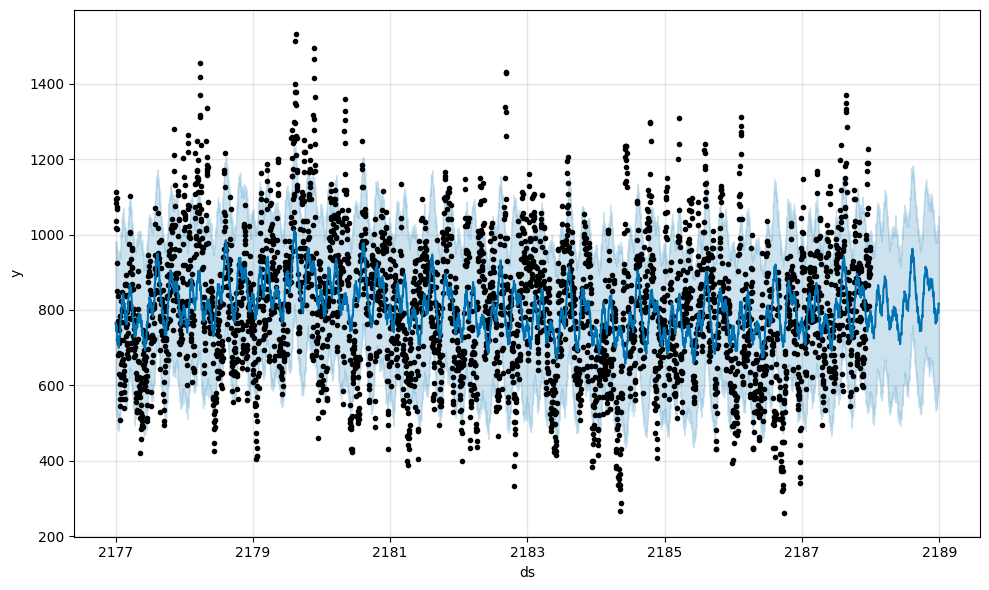

In [ ]:
fig2 = m2.plot(forecast2)

/usr/local/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

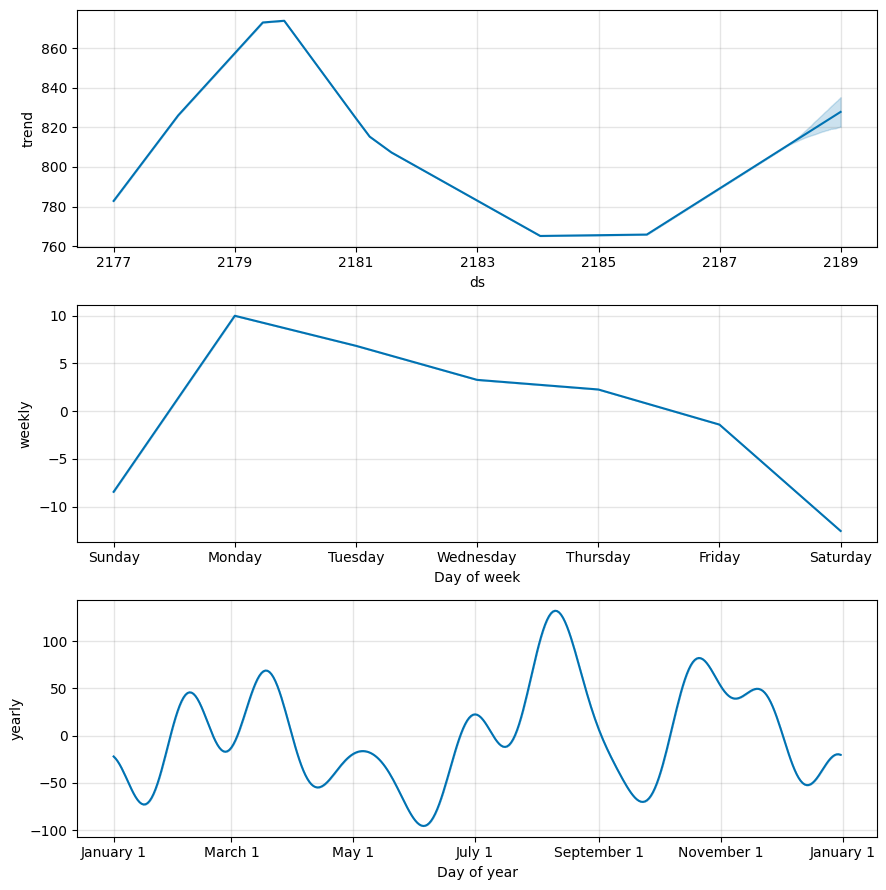

In [ ]:
fig2 = m2.plot_components(forecast2)

In [ ]:
future2.shape

(4382, 1)

narrow down to week

In [3]:
import os
import tensorflow

import matplotlib.pyplot as plt
import pandas as pd


from tensorflow import feature_column as fc


2024-06-12 06:14:43.387604: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 06:14:43.593513: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-12 06:14:43.593540: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-12 06:14:43.613552: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-12 06:14:44.964996: W tensorflow/stream_executor/platform/de

In [4]:
from tensorflow import keras

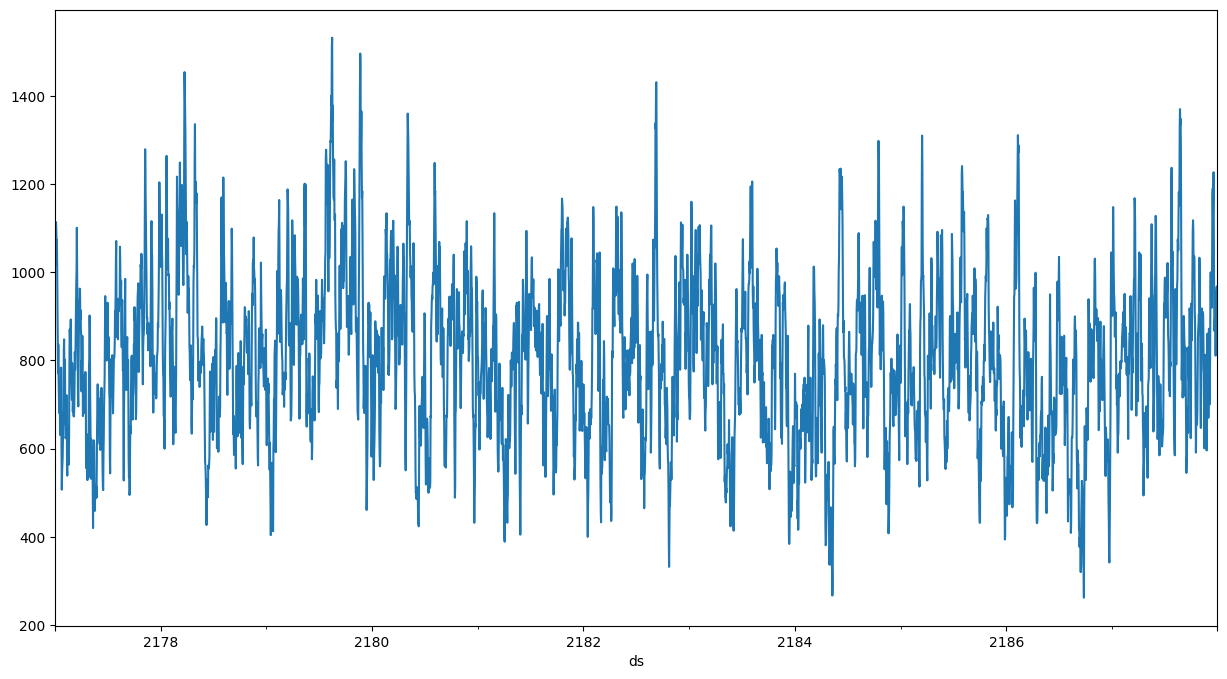

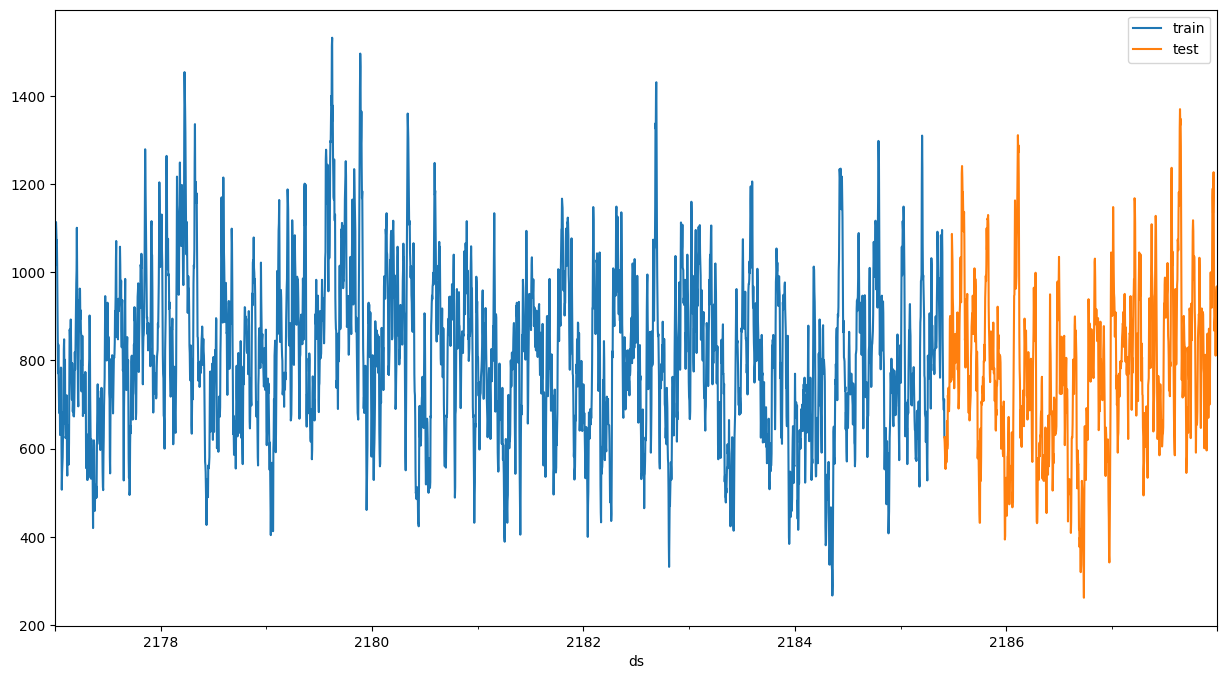

In [5]:
# normalize the dataset
new_keeras =  new.copy(deep=True)

new_keeras['ds'] = pd.to_datetime(new_keeras['ds'])
df_chg= new_keeras.set_index(['ds'], drop=True)
plt.figure(figsize=(15,8))
df_chg['y'].plot()
# Create a deep copy of the DataFrame


# Ensure 'ds' is in datetime format
# new_keeras['ds'] = pd.to_datetime(new_keeras['ds'])

# Define the split date
split_date = pd.Timestamp('2185-06-01')

df_1 = df_chg['y']
# Split the DataFrame into train and test sets
train = df_1.loc[:split_date]
test = df_1.loc[split_date:]
plt.figure(figsize=(15,8))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);



In [62]:

train_processed = df_chg.iloc[:, 0:1].values
train_processed = train_processed[0:3074:1]
test_processed = df_chg.iloc[:, 0:1].values
test_processed = test_processed[2130:3074:1]

print(len(train))
print(len(test))

3074
944


In [63]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
train_sc = scaler.fit_transform(train_processed)
test_sc = scaler.transform(test_processed)

In [64]:
X_train = train_sc[:-1]
y_train = train_sc[1:]
X_test = test_sc[:-1]
y_test = test_sc[1:]



In [13]:
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

In [54]:

nn_model = Sequential()
# nn_model.add(Dense(12, input_dim=1, activation='relu'))

# First hidden layer
nn_model.add(Dense(64, input_dim=1, activation='relu'))

# Second hidden layer
nn_model.add(Dense(32, activation='relu'))

# Third hidden layer
nn_model.add(Dense(16, activation='relu'))

nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=50, batch_size=5, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/50
426/426 [==============================] - 2s 3ms/step - loss: 0.0243
Epoch 2/50
426/426 [==============================] - 1s 3ms/step - loss: 0.0134
Epoch 3/50
426/426 [==============================] - 1s 3ms/step - loss: 0.0134
Epoch 4/50
426/426 [==============================] - 1s 3ms/step - loss: 0.0134
Epoch 5/50
426/426 [==============================] - 1s 3ms/step - loss: 0.0134
Epoch 6/50
426/426 [==============================] - 1s 3ms/step - loss: 0.0133
Epoch 7/50
426/426 [==============================] - 1s 3ms/step - loss: 0.0133
Epoch 8/50
426/426 [==============================] - 1s 3ms/step - loss: 0.0133
Epoch 9/50
426/426 [==============================] - 1s 3ms/step - loss: 0.0133
Epoch 10/50
426/426 [==============================] - 1s 3ms/step - loss: 0.0133
Epoch 11/50
426/426 [==============================] - 1s 3ms/step - loss: 0.0133
Epoch 12/50
426/426 [==============================] - 1s 3ms/step - loss: 0.0133
Epoch 13/50
426/426 [====

In [55]:
y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))

67/67 [==============================] - 0s 3ms/step
The R2 score on the Train set is:	0.862
The R2 score on the Test set is:	0.869


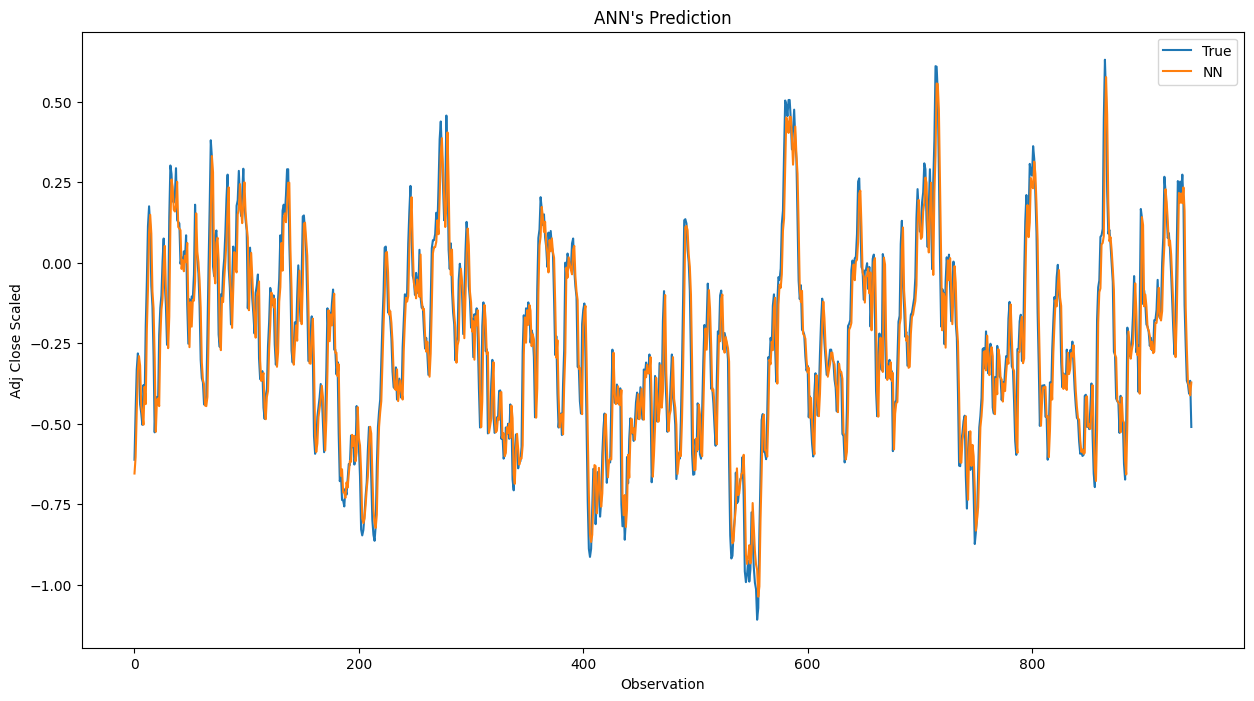

In [58]:
plt.figure(figsize=(15, 8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_nn, label='NN')
plt.title("ANN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show();

In [65]:
print(train_sc.shape)
print(test_sc.shape)
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)


for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train['X_1']
y_train = y_train['Y']
X_test = X_test['X_1']
y_test = y_test['Y']

X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

(3074, 1)
(944, 1)


In [66]:
X_train_lmse = X_train.reshape(X_train.shape[0], 1, 1)
X_test_lmse = X_test.reshape(X_test.shape[0], 1, 1)

print('Train shape: ', X_train_lmse.shape)
print('Test shape: ', X_test_lmse.shape)

Train shape:  (3073, 1, 1)
Test shape:  (943, 1, 1)


In [67]:
lstm_model = Sequential()
lstm_model.add(LSTM(30, input_shape=(1, X_train_lmse.shape[1]), activation='leaky_relu', kernel_initializer='lecun_normal', return_sequences=False))

lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')


early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)


history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=50, batch_size=2, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/50
1537/1537 [==============================] - 8s 4ms/step - loss: 0.0199
Epoch 2/50
1537/1537 [==============================] - 6s 4ms/step - loss: 0.0116
Epoch 3/50
1537/1537 [==============================] - 6s 4ms/step - loss: 0.0114
Epoch 4/50
1537/1537 [==============================] - 6s 4ms/step - loss: 0.0114
Epoch 5/50
1537/1537 [==============================] - 6s 4ms/step - loss: 0.0114
Epoch 6/50
1537/1537 [==============================] - 6s 4ms/step - loss: 0.0114
Epoch 7/50
1537/1537 [==============================] - 6s 4ms/step - loss: 0.0114
Epoch 8/50
1537/1537 [==============================] - 6s 4ms/step - loss: 0.0114
Epoch 9/50
1537/1537 [==============================] - 6s 4ms/step - loss: 0.0114
Epoch 10/50
1537/1537 [==============================] - 6s 4ms/step - loss: 0.0114
Epoch 11/50
1537/1537 [==============================] - 6s 4ms/step - loss: 0.0114
Epoch 12/50
1537/1537 [==============================] - 6s 4ms/step - loss: 0.0114
E

In [68]:
y_pred_test_lstm = lstm_model.predict(X_test_lmse)
y_train_pred_lstm = lstm_model.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

97/97 [==============================] - 0s 2ms/step
The R2 score on the Train set is:	0.867
The R2 score on the Test set is:	0.869


In [71]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.activations import relu, tanh, sigmoid
from keras.initializers import lecun_normal, glorot_normal
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

def create_lstm_model(units=30, activation='relu', kernel_initializer='glorot_normal'):
    model = Sequential()
    model.add(LSTM(units, input_shape=(1, X_train_lmse.shape[1]), activation=activation, kernel_initializer=kernel_initializer, return_sequences=False))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model



lstm_model = KerasRegressor(build_fn=create_lstm_model, epochs=25, batch_size=2, verbose=1)


param_grid = {
    'units': [10, 20, 30],  # You can add more values for hyperparameters
    'activation': ['relu', 'tanh', 'sigmoid'],
    'kernel_initializer': ['glorot_normal', 'lecun_normal']
}
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)

grid_search = GridSearchCV(estimator=lstm_model, param_grid=param_grid, cv=3)
grid_result = grid_search.fit(X_train_lmse, y_train,callbacks=[early_stop])

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


1024/1024 [==============================] - 3s 3ms/step - loss: 0.0115
Epoch 3/25
1024/1024 [==============================] - 3s 3ms/step - loss: 0.0113
Epoch 4/25
1024/1024 [==============================] - 3s 3ms/step - loss: 0.0113
Epoch 5/25
1024/1024 [==============================] - 3s 3ms/step - loss: 0.0113
Epoch 5: early stopping
513/513 [==============================] - 2s 2ms/step - loss: 0.0115
Epoch 1/25
1025/1025 [==============================] - 5s 3ms/step - loss: 0.0249
Epoch 2/25
1025/1025 [==============================] - 3s 3ms/step - loss: 0.0117
Epoch 3/25
1025/1025 [==============================] - 3s 3ms/step - loss: 0.0115
Epoch 4/25
1025/1025 [==============================] - 3s 3ms/step - loss: 0.0115
Epoch 5/25
1025/1025 [==============================] - 3s 3ms/step - loss: 0.0114
Epoch 6/25
1025/1025 [==============================] - 3s 3ms/step - loss: 0.0115
Epoch 7/25
1025/1025 [==============================] - 3s 3ms/step - loss: 0.0113
Epoc

## Best: -0.011235 using {'activation': 'tanh', 'kernel_initializer': 'glorot_normal', 'units': 30}

In [75]:
opt_lstm_model = Sequential()
opt_lstm_model.add(LSTM(30, input_shape=(1, X_train_lmse.shape[1]), activation='tanh', kernel_initializer='glorot_normal', return_sequences=False))

opt_lstm_model.add(Dense(1))
opt_lstm_model.compile(loss='mean_squared_error', optimizer='adam')


opt_early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)


opt_history_lstm_model = opt_lstm_model.fit(X_train_lmse, y_train, epochs=50, batch_size=2, verbose=1, shuffle=False, callbacks=[opt_early_stop])

Epoch 1/50
1537/1537 [==============================] - 10s 4ms/step - loss: 0.0213
Epoch 2/50
1537/1537 [==============================] - 7s 4ms/step - loss: 0.0115
Epoch 3/50
1537/1537 [==============================] - 7s 4ms/step - loss: 0.0115
Epoch 4/50
1537/1537 [==============================] - 7s 4ms/step - loss: 0.0115
Epoch 5/50
1537/1537 [==============================] - 7s 4ms/step - loss: 0.0115
Epoch 6/50
1537/1537 [==============================] - 7s 4ms/step - loss: 0.0115
Epoch 7/50
1537/1537 [==============================] - 7s 4ms/step - loss: 0.0115
Epoch 8/50
1537/1537 [==============================] - 7s 4ms/step - loss: 0.0115
Epoch 9/50
1537/1537 [==============================] - 7s 4ms/step - loss: 0.0115
Epoch 10/50
1537/1537 [==============================] - 7s 4ms/step - loss: 0.0115
Epoch 11/50
1537/1537 [==============================] - 7s 4ms/step - loss: 0.0115
Epoch 12/50
1537/1537 [==============================] - 7s 4ms/step - loss: 0.0115


In [76]:
y_pred_test_lstm_opt = opt_lstm_model.predict(X_test_lmse)
y_train_pred_lstm_opt = opt_lstm_model.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm_opt)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm_opt)))

97/97 [==============================] - 0s 3ms/step
The R2 score on the Train set is:	0.866
The R2 score on the Test set is:	0.868


The hyper parameter tuning results are not yielding the best test results. We can try to forecast at a subsection level and combine those predictions. This could be unit level [icu,nn,pacu] or a single ward level although number might be too low to predict accurately.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=32fd6ad5-d688-4e0a-9fc6-55e2a5bea8cc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>